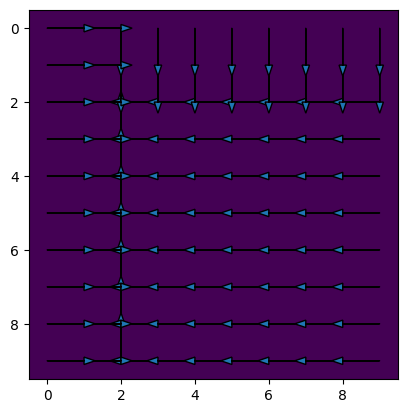

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

# H = np.zeros([100,100])

# H[10:80,10:20] = 1
# H[40:48,30:75] = 1
# H[0:40, 50:52] = 1
# H[75: 85, 50: 100] = 1

H = np.zeros([10,10])
# plt.imshow(H, interpolation='none')
# plt.show()

start = (2,2)
frontier = []
frontier.append(start)
came_from = dict()
came_from[start] = None
directions = [(0,1),(1,0),(0,-1),(-1,0)]
while len(frontier) > 0:
    current = frontier.pop(0)
    for direction in directions:
        nextval = (direction[0] + current[0], direction[1] + current[1])
        if nextval[0] >= 0 and nextval[0] < len(H) and nextval[1] >= 0 and nextval[1] < len(H[0]) and nextval not in came_from:   
            frontier.append(nextval)
            came_from[nextval] = current

for key in came_from:
    point = came_from[key]
    # print(point)
    # print(key)
    if point:
        plt.arrow(key[0],key[1],point[0]-key[0],point[1]-key[1],head_width = 0.2)
plt.imshow(H, interpolation='none')
plt.show()